In [ ]:
from datetime import date
import json

import openfisca_france
from openfisca_france.model.base import *

#importer numpy permet de coler deux sections de courbes (nécessaire quand on fait varier le salaire de base en-dessous du SMIC mensuel)
import numpy as np

# to debug / trace
from openfisca_core import tools
from openfisca_core.reforms import Reform

# Système socio-fiscal

In [2]:
tax_benefit_system = openfisca_france.FranceTaxBenefitSystem()

# Réforme : 1. Revenu de base par CSG

In [3]:
from numpy import logical_not as not_, minimum as min_, maximum as max_, logical_and as and_, logical_or as or_
#- Hausse de la CSG déductible au taux de 23%
#- Mise en place d'un revenu de base adulte égal à RSA socle célibataire - forfait logement célibataire = 
#- Intégrer le revenu de base au revenu disponible
#- Mise en place d'un crédit d'impot familles monoparentales montant de 150 Euros
#- Supprimer le RSA

# Ajouté par robert : supprimer l'ASPA


#-Visualisation graphique en abscisse salaire brut et en ordonnée variation du revenu disponible 
# pour un célibataire sans enfant
# pour un couple sans enfant
# une famille monoparentale


#(- Nouveau calcul de l'IRPP)


In [4]:
#- Hausse de la CSG déductible au taux de 23%
# montant_csg_crds calculé à partir du paramètre "csg.activite.deductible.taux"

def modify_legislation_json(reference_legislation_json_copy): # Il s'agit d'une fonction et d'une méthode de "reforms"
    for value_json in reference_legislation_json_copy['children']['csg']['children']['activite']['children']['deductible']['children']['taux']['values']:
        value_json['value'] = 0.23
    return reference_legislation_json_copy


In [5]:
#- Mise en place d'un revenu de base adulte égal à RSA socle célibataire - forfait logement célibataire

class rdb(Variable): # Création d'une nouvelle classe
    column = FloatCol
    entity_class = Individus
    label = u"Revenu de base"

    def function(self, simulation, period):
        period = period.start.offset('first-of', 'month').period('month')
        age = simulation.calculate('age') 
        rmi = simulation.legislation_at(period.start).minim.rmi
        
        return period, ((age >= 18) * rmi.rmi * ( 1 -rmi.forfait_logement.taux1) + not_(age >= 18) * 0)

In [6]:
# On enlève les enfants du calcul du nbptr (quotient_familial.enf*)
class nbptr(Variable): # Modification de la classe nbptr
    def function(self, simulation, period):
        '''
        Nombre de parts du foyer
        'foy'
        note 1 enfants et résidence alternée (formulaire 2041 GV page 10)

        quotient_familial.conj : nb part associées au conjoint d'un couple marié ou pacsé
        quotient_familial.enf1 : nb part 2 premiers enfants
        quotient_familial.enf2 : nb part enfants de rang 3 ou plus
        quotient_familial.inv1 : nb part supp enfants invalides (I, G)
        quotient_familial.inv2 : nb part supp adultes invalides (R)
        quotient_familial.not31 : nb part supp note 3 : cases W ou G pour veuf, celib ou div
        quotient_familial.not32 : nb part supp note 3 : personne seule ayant élevé des enfants
        quotient_familial.not41 : nb part supp adultes invalides (vous et/ou conjoint) note 4
        quotient_familial.not42 : nb part supp adultes anciens combattants (vous et/ou conjoint) note 4
        quotient_familial.not6 : nb part supp note 6
        quotient_familial.isol : demi-part parent isolé (T)
        quotient_familial.edcd : enfant issu du mariage avec conjoint décédé;
        '''
        period = period.start.offset('first-of', 'month').period('year')
        nb_pac = simulation.calculate('nb_pac', period)
        maries_ou_pacses = simulation.calculate('maries_ou_pacses', period)
        celibataire_ou_divorce = simulation.calculate('celibataire_ou_divorce', period)
        veuf = simulation.calculate('veuf', period)
        jeune_veuf = simulation.calculate('jeune_veuf', period)
        nbF = simulation.calculate('nbF', period)
        nbG = simulation.calculate('nbG', period)
        nbH = simulation.calculate('nbH', period)
        nbI = simulation.calculate('nbI', period)
        nbR = simulation.calculate('nbR', period)
        nbJ = simulation.calculate('nbJ', period)
        caseP = simulation.calculate('caseP', period)
        caseW = simulation.calculate('caseW', period)
        caseG = simulation.calculate('caseG', period)
        caseE = simulation.calculate('caseE', period)
        caseK = simulation.calculate('caseK', period)
        caseN = simulation.calculate('caseN', period)
        caseF = simulation.calculate('caseF', period)
        caseS = simulation.calculate('caseS', period)
        caseL = simulation.calculate('caseL', period)
        caseT = simulation.calculate('caseT', period)
        quotient_familial = simulation.legislation_at(period.start).ir.quotient_familial

        no_pac = nb_pac == 0  # Aucune personne à charge en garde exclusive
        has_pac = not_(no_pac)
        no_alt = nbH == 0  # Aucun enfant à charge en garde alternée
        has_alt = not_(no_alt)

        # # nombre de parts liées aux enfants à charge
        # que des enfants en résidence alternée
        enf1 = (no_pac & has_alt) * (quotient_familial.enf1 * min_(nbH, 2) * 0.5
                                     + quotient_familial.enf2 * max_(nbH - 2, 0) * 0.5)
        # pas que des enfants en résidence alternée
        enf2 = (has_pac & has_alt) * ((nb_pac == 1) * (quotient_familial.enf1 * min_(nbH, 1) * 0.5
            + quotient_familial.enf2 * max_(nbH - 1, 0) * 0.5) + (nb_pac > 1) * (quotient_familial.enf2 * nbH * 0.5))
        # pas d'enfant en résidence alternée
        enf3 = quotient_familial.enf1 * min_(nb_pac, 2) + quotient_familial.enf2 * max_((nb_pac - 2), 0)

        enf = enf1 + enf2 + enf3
        # # note 2 : nombre de parts liées aux invalides (enfant + adulte)
        n2 = quotient_familial.inv1 * (nbG + nbI / 2) + quotient_familial.inv2 * nbR

        # # note 3 : Pas de personne à charge
        # - invalide

        n31a = quotient_familial.not31a * (no_pac & no_alt & caseP)
        # - ancien combatant
        n31b = quotient_familial.not31b * (no_pac & no_alt & (caseW | caseG))
        n31 = max_(n31a, n31b)
        # - personne seule ayant élevé des enfants
        n32 = quotient_familial.not32 * (no_pac & no_alt & ((caseE | caseK) & not_(caseN)))
        n3 = max_(n31, n32)
        # # note 4 Invalidité de la personne ou du conjoint pour les mariés ou
        # # jeunes veuf(ve)s
        n4 = max_(quotient_familial.not41 * (1 * caseP + 1 * caseF), quotient_familial.not42 * (caseW | caseS))

        # # note 5
        #  - enfant du conjoint décédé
        n51 = quotient_familial.cdcd * (caseL & ((nbF + nbJ) > 0))
        #  - enfant autre et parent isolé
        n52 = quotient_familial.isol * caseT * (((no_pac & has_alt) * ((nbH == 1) * 0.5 + (nbH >= 2))) + 1 * has_pac)
        n5 = max_(n51, n52)

        # # note 6 invalide avec personne à charge
        n6 = quotient_familial.not6 * (caseP & (has_pac | has_alt))

        # # note 7 Parent isolé
        n7 = quotient_familial.isol * caseT * ((no_pac & has_alt) * ((nbH == 1) * 0.5 + (nbH >= 2)) + 1 * has_pac)

        # # Régime des mariés ou pacsés
        #m = 1 + quotient_familial.conj + enf + n2 + n4
        m = 1 + quotient_familial.conj + n2 + n4
        
        # # veufs  hors jeune_veuf
        # v = 1 + enf + n2 + n3 + n5 + n6
        v = 1 + n2 + n3 + n5 + n6
        
        # # celib div
        #c = 1 + enf + n2 + n3 + n6 + n7
        c = 1 + n2 + n3 + n6 + n7

        return period, (maries_ou_pacses | jeune_veuf) * m + (veuf & not_(jeune_veuf)) * v + celibataire_ou_divorce * c


In [7]:
# Suppression des allocations familiales

class af(Variable):
    def function(self, simulation, period):
        period = period.this_month
        af_base = simulation.calculate('af_base', period)
        af_majoration = simulation.calculate('af_majoration', period)
        af_allocation_forfaitaire = simulation.calculate('af_allocation_forfaitaire', period)

        #return period, af_base + af_majoration + af_allocation_forfaitaire
        return period, af_base * 0

In [8]:
from numpy import round

# Suppression du complément familial

class cf(Variable):
    def function(self, simulation, period):
        '''
        L'allocation de base de la paje n'est pas cumulable avec le complément familial
        '''
        period = period.this_month
        paje_base = simulation.calculate('paje_base', period)
        apje_avant_cumul = simulation.calculate('apje_avant_cumul', period)
        ape_avant_cumul = simulation.calculate('ape_avant_cumul', period)
        cf_montant = simulation.calculate('cf_montant', period)
        residence_mayotte = simulation.calculate('residence_mayotte', period)

        cf_brut = not_(paje_base) * (apje_avant_cumul <= cf_montant) * (ape_avant_cumul <= cf_montant) * cf_montant
        # return period, not_(residence_mayotte) * round(cf_brut, 2)
        return period, not_(residence_mayotte) * round(cf_brut, 2) * 0

In [9]:
# Suppression de l'allocation de rentrée scolaire

class ars(Variable):
    def function(self, simulation, period):
        '''
        Allocation de rentrée scolaire brute de CRDS
        '''
        period_br = period.this_year
        return period_br, self.zeros()

In [10]:
# Création d'un revenu de base enfant - Version individus au niveau des allocations familliales actuelles

class rdb_enf(Variable):
    column = FloatCol
    entity_class = Individus
    label = u"Revenu de base enfant"

    def function(self, simulation, period):
        period = period.start.offset('first-of', 'month').period('month')
        age = simulation.calculate('age')
        P = simulation.legislation_at(period.start).fam.af        
        bmaf = P.bmaf
        
        return period, ((age < 14) * 0.41 + not_(age < 14) * 0.57) * bmaf * (age <= 18)

In [11]:
#- Mise en place d'un crédit d'impot familles monoparentales montant (150€)
class credit_impot_monoparentales(Variable):
    column = FloatCol
    entity_class = Menages
    label = u"credit_impot_monoparentales"

    def function(self, simulation, period):
        period = period.start.offset('first-of', 'month').period('month')
        enfant_a_charge_holder = simulation.compute('enfant_a_charge', period)
        enfant_a_charge = self.sum_by_entity(enfant_a_charge_holder)
        caseT = simulation.calculate('caseT', period) #Egal True si le parent est isolé
      
        #return period, or_(and_(age_holder >= 18, nb_enf_a_charge > 0, caseT), or_(age_holder < 18, nb_enf_a_charge <= 0, not_(caseT)) * 0) * 100
        return period, (enfant_a_charge > 0) * caseT * 150
    #Si le parent est isolé, avec au moins un enfant, et qu'il est majeur il reçoit la pension

In [12]:
#- Supprimer le RSA
class rsa_socle(Variable):
    def function(self, simulation, period):
        period = period.this_month
        nb_parents = simulation.calculate('nb_parents', period)
        eligib = simulation.calculate('rsa_eligibilite', period)
        rsa_nb_enfants = simulation.calculate('rsa_nb_enfants', period)
        rmi = simulation.legislation_at(period.start).minim.rmi

        nbp = nb_parents + rsa_nb_enfants

        taux = (
            1 +
            (nbp >= 2) * rmi.txp2 +
            (nbp >= 3) * rmi.txp3 +
            (nbp >= 4) * ((nb_parents == 1) * rmi.txps + (nb_parents != 1) * rmi.txp3) +
            max_(nbp - 4, 0) * rmi.txps
        )
        #on met à zéro
        return period, eligib * rmi.rmi * taux * 0

In [13]:
# Supprimer l'ASPA
class aspa(Variable):
    
    def function(self, simulation, period):
        period = period.this_month
        return period, self.zeros()
    




In [14]:
#- Intégrer le revenu de base, le rdb_enfant et le crédit impôt enfant au revenu disponible
class revdisp(Variable):
    def function(self, simulation, period):
        '''
        Revenu disponible - ménage
        'men'
        '''
        period = period.start.period('year').offset('first-of')
        rev_trav_holder = simulation.compute('rev_trav', period)
        pen_holder = simulation.compute('pen', period)
        rev_cap_holder = simulation.compute('rev_cap', period)
        psoc_holder = simulation.compute('psoc', period)
        ppe_holder = simulation.compute('ppe', period)
        impo = simulation.calculate('impo', period)
        rdb_holder = simulation.calculate_add('rdb', period)
        credit_impot_familles_holder = simulation.calculate_add('credit_impot_monoparentales', period)
        rdb_enf_holder = simulation.calculate_add('rdb_enf', period)
        
        pen = self.sum_by_entity(pen_holder)
        ppe = self.cast_from_entity_to_role(ppe_holder, role = VOUS)
        ppe = self.sum_by_entity(ppe)
        psoc = self.cast_from_entity_to_role(psoc_holder, role = CHEF)
        psoc = self.sum_by_entity(psoc)
        rev_cap = self.sum_by_entity(rev_cap_holder)
        rev_trav = self.sum_by_entity(rev_trav_holder)
        rdb = self.sum_by_entity(rdb_holder)
        rdb_enf = self.sum_by_entity(rdb_enf_holder)
        
           #  credit_impot_monoparentales = self.sum_by_entity(credit_impot_familles_holder) # Ajouté par Robert le 02/08
        
        return period, rev_trav + pen + rev_cap + psoc + ppe + impo + rdb + credit_impot_familles_holder + rdb_enf
    
      #  return period, rev_trav + pen + rev_cap + psoc + ppe + impo + rdb + credit_impot_monoparentales + rdb_enf # ajouté par Robert

In [15]:
class ReformeRevenuDeBaseparCSG(Reform):
    name = u"Réforme Revenu de base par CSG"

    def apply(self):
        for variable in [rdb, nbptr, af, cf, ars, rdb_enf, credit_impot_monoparentales, rsa_socle, revdisp, aspa]:
            self.update_variable(variable)
        self.modify_legislation_json(modifier_function = modify_legislation_json)

# Tests

In [16]:
reform = ReformeRevenuDeBaseparCSG(tax_benefit_system)

In [17]:
# parent1_salaire_de_base = 9700
parent1_asi_aspa_base_ressources_individu = 8000/12
#parent1_salaire_de_base = 50000


In [18]:
scenario_ref_individu_seul = reform.new_scenario().init_single_entity(
    period = 2016,
    parent1 = dict(
        date_naissance = date(1950, 1, 1),
        asi_aspa_base_ressources_individu = parent1_asi_aspa_base_ressources_individu, # concerne l'aspa
        statut_marital = u'Célibataire',
        ),
    foyer_fiscal = dict(
        caseT = True,
        ),
    enfants = [
        dict(date_naissance = date(2010, 1, 1),),
       ],
    )
    

In [19]:
simulation_ref_individu_seul = scenario_ref_individu_seul.new_simulation(debug = True)

In [20]:
df_aspa = simulation_ref_individu_seul.calculate('aspa')
print df_aspa * 12, "annuels"

AssertionError: Requested period 2016 differs from 2016-01 returned by variable aspa

In [21]:
scenario_rdb_individu_seul = reform.new_scenario().init_single_entity(
    period = 2016,
    parent1 = dict(
        date_naissance = date(1950, 1, 1),
        asi_aspa_base_ressources_individu = parent1_asi_aspa_base_ressources_individu,
        # salaire_de_base = parent1_salaire_de_base,
        statut_marital = u'Célibataire',
        ),
    foyer_fiscal = dict(
        caseT = True,
        ),
    enfants = [
        dict(date_naissance = date(2010, 1, 1),),
       ],
    )

In [ ]:
simulation_rdb_individu_seul = scenario_rdb_individu_seul.new_simulation(debug = True)

In [ ]:
df_aspa = simulation_rdb_individu_seul.calculate('aspa')
print df_aspa * 12, "annuels"

Calculs de référence (revenu disponible, IR, RSA, CSG imposable/deductible, impot total) 

In [ ]:
# simulation_ref_individu_seul.calculate('revdisp')
# from openfisca_core import tools
# print(tools.get_trace_tool_link(scenario_ref_individu_seul, ['revdisp'], api_url='http://api.openfisca.fr/', trace_tool_url='http://www.openfisca.fr/tools/trace'))


In [ ]:
df_revdisp = simulation_ref_individu_seul.calculate('revdisp')
print df_revdisp


In [ ]:
df_rev_trav = simulation_ref_individu_seul.calculate('rev_trav')

In [ ]:
df_irpp = simulation_ref_individu_seul.calculate('irpp')



In [ ]:
fd_ars = simulation_ref_individu_seul.calculate('ars')

In [ ]:
df_rsa = simulation_ref_individu_seul.calculate_add('rsa')


In [ ]:
df_psoc = simulation_ref_individu_seul.calculate_add('psoc')

In [ ]:
df_impo = simulation_ref_individu_seul.calculate('impo')

In [ ]:
df_csg_imposable_salaire = simulation_ref_individu_seul.calculate('csg_imposable_salaire')

In [ ]:
df_csg_deductible_salaire = simulation_ref_individu_seul.calculate('csg_deductible_salaire')

In [ ]:
df_tot_impot = simulation_ref_individu_seul.calculate('tot_impot')

In [ ]:
df_cotisations_salariales = simulation_ref_individu_seul.calculate('cotisations_salariales')


In [ ]:
simulation_ref_individu_seul.calculate('nbptr')

Calculs avec réforme RDB (revenu disponible, IR, RSA, CSG imposable/deductible, impot total) 

In [ ]:
df_revdisp = simulation_rdb_individu_seul.calculate('revdisp')
# from openfisca_core import tools
# print(tools.get_trace_tool_link(scenario_rdb_individu_seul, ['revdisp'], api_url='http://api.openfisca.fr/', trace_tool_url='http://www.openfisca.fr/tools/trace'))



In [ ]:
df_rev_trav = simulation_rdb_individu_seul.calculate('rev_trav')

In [ ]:
df_psoc = simulation_rdb_individu_seul.calculate('psoc')

In [ ]:
df_impo = simulation_rdb_individu_seul.calculate('impo')

In [ ]:
simulation_rdb_individu_seul.calculate('salaire_imposable')

In [ ]:
simulation_rdb_individu_seul.calculate('nbptr')

In [ ]:
simulation_rdb_individu_seul.calculate_add('rsa')

In [ ]:
simulation_rdb_individu_seul.calculate('irpp')

In [ ]:
simulation_rdb_individu_seul.calculate('csg_imposable_salaire')


In [ ]:
simulation_rdb_individu_seul.calculate('csg_deductible_salaire')

In [ ]:
simulation_rdb_individu_seul.calculate('tot_impot')

In [ ]:
df_rdb = simulation_rdb_individu_seul.calculate('rdb')


In [ ]:
df_rdb_enf = simulation_rdb_individu_seul.calculate('rdb_enf')

In [ ]:
df_cim = simulation_rdb_individu_seul.calculate('credit_impot_monoparentales')

In [ ]:
simulation_rdb_individu_seul.calculate('cotisations_salariales')

Présentation des résultats des tests

In [ ]:
import pandas

contr_revdisp = df_rev_trav[0] + df_psoc[0] + df_impo[0] + [df_rdb[0]] + df_rdb_enf[1] + [df_cim[0]]
df = pandas.DataFrame({'RevDisp': [df_revdisp[0]],'RevTrav': [df_rev_trav[0]], 'Psoc' : [df_psoc[0]], 'Imp' : [df_impo[0]], 
                       'RdB': [df_rdb[0]],'RdB Enfant': [df_rdb_enf[1]], 'Credit impot': [df_cim[0]], 'Contr revdisp' : [contr_revdisp[0]] }) 
                                                                                       
frame = pandas.DataFrame(df, columns=['RevDisp', 'RevTrav', 'Psoc', 'Imp', 'RdB', 'RdB Enfant','Credit impot', 'Contr revdisp'])

frame1 = round(frame,2)

print frame1






## Graphiques: scenario variant selon salaire_de_base (0 => 60k par palier de 5k)
nb_pla = 5000
min_salaire_de_base = 0
max_salaire_de_base = 60000

In [23]:
min_salaire_de_base = 0
max_salaire_de_base = 120000
pas = 5000
nb_palier = max_salaire_de_base / pas

In [24]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [25]:
def make_two_parents_scenario(nombre_enfants = 1, year = None, tax_benefit_system = tax_benefit_system):
    enfant = [dict(
        date_naissance = date(2005, 1, 1),
        )]
    enfants = enfant * nombre_enfants
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [[
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year-1,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year-2,            
                )
            ]],
        period = year,
        parent1 = dict(
            date_naissance = date(1980, 1, 1),
            ),
        parent2 = dict(
            date_naissance = date(1980, 1, 1),
            ),
        enfants = enfants,
        menage = dict(
            loyer = 5000,
            statut_occupation_logement = 4,
            ),
        )  
    
    return scenario


In [26]:
def make_one_parent_scenario(nombre_enfants = 0, year = None, tax_benefit_system = tax_benefit_system):
    enfant = [dict(
        date_naissance = date(2005, 1, 1),
        )]
    enfants = enfant * nombre_enfants
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [[
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year-1,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year-2,            
                )
            ]],
        period = year,
        parent1 = dict(
            date_naissance = date(1980, 1, 1),
            ),
        enfants = enfants,
        menage = dict(
            loyer = 5000,
            statut_occupation_logement = 4,
            ),
        )
    
    return scenario

In [27]:
scenario_p2_e0_ref = make_two_parents_scenario(0, 2015)
simulation_p2_e0_ref = scenario_p2_e0_ref.new_simulation()

In [28]:
scenario_p2_e0_rdb = make_two_parents_scenario(0, 2015, reform)
simulation_p2_e0_rdb = scenario_p2_e0_rdb.new_simulation()

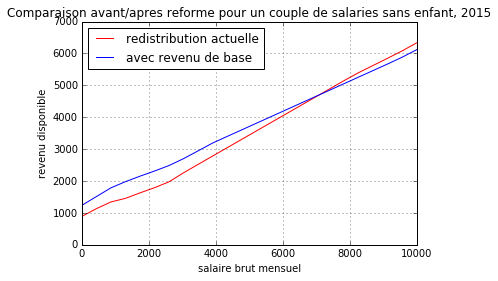

In [29]:
# comparaison du revenu disponible entre Reference et RDB
revenu_disponible_p2_e0_ref = simulation_p2_e0_ref.calculate_add("revdisp") / 12
revenu_disponible_p2_e0_rdb = simulation_p2_e0_rdb.calculate_add("revdisp") / 12 

salaire_de_base_p2_e0_ref = simulation_p2_e0_ref.calculate("salaire_de_base") / 12
salaire_de_base_p2_e0_rdb = simulation_p2_e0_rdb.calculate("salaire_de_base") / 12

# Attention à ne pas mettre d'accent (ex: "é") dans la légende
plt.plot(salaire_de_base_p2_e0_ref[::2], revenu_disponible_p2_e0_ref, 'r', label='redistribution actuelle')
plt.plot(salaire_de_base_p2_e0_rdb[::2], revenu_disponible_p2_e0_rdb, label='avec revenu de base')
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible")
plt.title("Comparaison avant/apres reforme pour un couple de salaries sans enfant, 2015")
plt.grid()
plt.legend(loc=2)



In [30]:
i = 0
print "RD_Actuel","  ", "RD_Réforme","  ", "SB_Actuel"

while i < 24:                                                                                                 
    print round(revenu_disponible_p2_e0_ref[i]),"      ", round(revenu_disponible_p2_e0_rdb[i]), "      ",   round(salaire_de_base_p2_e0_ref[i])
    i = i + 1

RD_Actuel    RD_Réforme    SB_Actuel
890.0        1238.0        0.0
1134.0        1513.0        0.0
1344.0        1787.0        435.0
1457.0        1981.0        0.0
1630.0        2153.0        870.0
1792.0        2315.0        0.0
1979.0        2488.0        1304.0
2262.0        2705.0        0.0
2526.0        2950.0        1739.0
2788.0        3196.0        0.0
3050.0        3402.0        2174.0
3312.0        3608.0        0.0
3574.0        3814.0        2609.0
3836.0        4021.0        0.0
4098.0        4227.0        3043.0
4360.0        4433.0        0.0
4622.0        4639.0        3478.0
4884.0        4845.0        0.0
5146.0        5051.0        3913.0
5396.0        5257.0        0.0
5623.0        5464.0        4348.0
5849.0        5670.0        0.0
6082.0        5883.0        4783.0
6333.0        6118.0        0.0


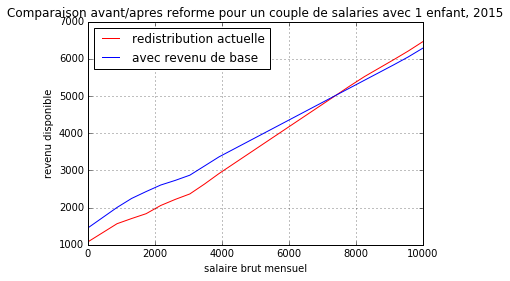

In [31]:
scenario_p2_e1_ref = make_two_parents_scenario(1, 2015)
simulation_p2_e1_ref = scenario_p2_e1_ref.new_simulation()
scenario_p2_e1_rdb = make_two_parents_scenario(1, 2015, reform)
simulation_p2_e1_rdb = scenario_p2_e1_rdb.new_simulation()
# comparaison du revenu disponible entre Reference et RDB
revenu_disponible_p2_e1_ref = simulation_p2_e1_ref.calculate_add("revdisp") / 12
revenu_disponible_p2_e1_rdb = simulation_p2_e1_rdb.calculate_add("revdisp") / 12

salaire_de_base_p2_e1_ref = simulation_p2_e1_ref.calculate("salaire_de_base") / 12
salaire_de_base_p2_e1_rdb = simulation_p2_e1_rdb.calculate("salaire_de_base") / 12

# Attention à ne pas mettre d'accent (ex: "é") dans la légende
plt.plot(salaire_de_base_p2_e1_ref[::3], revenu_disponible_p2_e1_ref, 'r', label='redistribution actuelle')
plt.plot(salaire_de_base_p2_e1_rdb[::3], revenu_disponible_p2_e1_rdb, label='avec revenu de base')
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible")
plt.title("Comparaison avant/apres reforme pour un couple de salaries avec 1 enfant, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
i = 0
print "RD_Actuel","  ", "RD_Réforme"
while i < 24:
    print round(revenu_disponible_p2_e1_ref[i]),"     ", round(revenu_disponible_p2_e1_rdb[i])
    i = i + 1

In [ ]:
scenario_p2_e2_ref = make_two_parents_scenario(2, 2015)
simulation_p2_e2_ref = scenario_p2_e2_ref.new_simulation()
scenario_p2_e2_rdb = make_two_parents_scenario(2, 2015, reform)
simulation_p2_e2_rdb = scenario_p2_e2_rdb.new_simulation()
# comparaison du revenu disponible entre Reference et RDB
revenu_disponible_p2_e2_ref = simulation_p2_e2_ref.calculate_add("revdisp") / 12
revenu_disponible_p2_e2_rdb = simulation_p2_e2_rdb.calculate_add("revdisp") / 12

salaire_de_base_p2_e2_ref = simulation_p2_e2_ref.calculate("salaire_de_base") / 12
salaire_de_base_p2_e2_rdb = simulation_p2_e2_rdb.calculate("salaire_de_base") / 12

# Attention à ne pas mettre d'accent (ex: "é") dans la légende
plt.plot(salaire_de_base_p2_e2_ref[::4], revenu_disponible_p2_e2_ref, 'r', label='redistribution actuelle')
plt.plot(salaire_de_base_p2_e2_rdb[::4], revenu_disponible_p2_e2_rdb, label='avec revenu de base')
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible")
plt.title("Comparaison avant/apres reforme pour un couple de salaries avec 2 enfants, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
scenario_p2_e3_ref = make_two_parents_scenario(3, 2015)
simulation_p2_e3_ref = scenario_p2_e3_ref.new_simulation()
scenario_p2_e3_rdb = make_two_parents_scenario(3, 2015, reform)
simulation_p2_e3_rdb = scenario_p2_e3_rdb.new_simulation()
# comparaison du revenu disponible entre Reference et RDB
revenu_disponible_p2_e3_ref = simulation_p2_e3_ref.calculate_add("revdisp") / 12
revenu_disponible_p2_e3_rdb = simulation_p2_e3_rdb.calculate_add("revdisp") / 12

salaire_de_base_p2_e3_ref = simulation_p2_e3_ref.calculate("salaire_de_base") / 12
salaire_de_base_p2_e3_rdb = simulation_p2_e3_rdb.calculate("salaire_de_base") / 12

# Attention à ne pas mettre d'accent (ex: "é") dans la légende
plt.plot(salaire_de_base_p2_e3_ref[::5], revenu_disponible_p2_e3_ref, 'r', label='redistribution actuelle')
plt.plot(salaire_de_base_p2_e3_rdb[::5], revenu_disponible_p2_e3_rdb, label='avec revenu de base')
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible")
plt.title("Comparaison avant/apres reforme pour un couple de salaries avec 3 enfants, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
scenario_p1_e0_ref = make_one_parent_scenario(0, 2015)
simulation_p1_e0_ref = scenario_p1_e0_ref.new_simulation()
scenario_p1_e0_rdb = make_one_parent_scenario(0, 2015, reform)
simulation_p1_e0_rdb = scenario_p1_e0_rdb.new_simulation()
# comparaison du revenu disponible entre Reference et RDB
revenu_disponible_p1_e0_ref = simulation_p1_e0_ref.calculate_add("revdisp") / 12
revenu_disponible_p1_e0_rdb = simulation_p1_e0_rdb.calculate_add("revdisp") / 12

salaire_de_base_p1_e0_ref = simulation_p1_e0_ref.calculate("salaire_de_base") / 12
salaire_de_base_p1_e0_rdb = simulation_p1_e0_rdb.calculate("salaire_de_base") / 12

# Attention à ne pas mettre d'accent (ex: "é") dans la légende
plt.plot(salaire_de_base_p1_e0_ref, revenu_disponible_p1_e0_ref, 'r', label='redistribution actuelle')
plt.plot(salaire_de_base_p1_e0_rdb, revenu_disponible_p1_e0_rdb, label='avec revenu de base')
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible")
plt.title("Comparaison avant/apres reforme pour un salarie sans enfant, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
scenario_p1_e1_ref = make_one_parent_scenario(1, 2015)
simulation_p1_e1_ref = scenario_p1_e1_ref.new_simulation()
scenario_p1_e1_rdb = make_one_parent_scenario(1, 2015, reform)
simulation_p1_e1_rdb = scenario_p1_e1_rdb.new_simulation()
# comparaison du revenu disponible entre Reference et RDB
revenu_disponible_p1_e1_ref = simulation_p1_e1_ref.calculate_add("revdisp") / 12
revenu_disponible_p1_e1_rdb = simulation_p1_e1_rdb.calculate_add("revdisp") / 12

salaire_de_base_p1_e1_ref = simulation_p1_e1_ref.calculate("salaire_de_base") / 12
salaire_de_base_p1_e1_rdb = simulation_p1_e1_rdb.calculate("salaire_de_base") / 12

# Attention à ne pas mettre d'accent (ex: "é") dans la légende
plt.plot(salaire_de_base_p1_e1_ref[::2], revenu_disponible_p1_e1_ref, 'r', label='redistribution actuelle')
plt.plot(salaire_de_base_p1_e1_rdb[::2], revenu_disponible_p1_e1_rdb, label='avec revenu de base')
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible")
plt.title("Comparaison avant/apres reforme pour un salarie avec 1 enfant, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
scenario_p1_e2_ref = make_one_parent_scenario(2, 2015)
simulation_p1_e2_ref = scenario_p1_e2_ref.new_simulation()
scenario_p1_e2_rdb = make_one_parent_scenario(2, 2015, reform)
simulation_p1_e2_rdb = scenario_p1_e2_rdb.new_simulation()
# comparaison du revenu disponible entre Reference et RDB
revenu_disponible_p1_e2_ref = simulation_p1_e2_ref.calculate_add("revdisp") / 12
revenu_disponible_p1_e2_rdb = simulation_p1_e2_rdb.calculate_add("revdisp") / 12

salaire_de_base_p1_e2_ref = simulation_p1_e2_ref.calculate("salaire_de_base") / 12
salaire_de_base_p1_e2_rdb = simulation_p1_e2_rdb.calculate("salaire_de_base") / 12

# Attention à ne pas mettre d'accent (ex: "é") dans la légende
# pour linestyle, cf. http://matplotlib.org/api/pyplot_api.html
plt.plot(salaire_de_base_p1_e2_ref[::3], revenu_disponible_p1_e2_ref, 'k',linestyle='--', label='redistribution actuelle')
plt.plot(salaire_de_base_p1_e2_rdb[::3], revenu_disponible_p1_e2_rdb, 'k', label='avec revenu de base')
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible")
plt.title("Comparaison avant/apres reforme pour un salarie avec 2 enfants, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
plt.plot(salaire_de_base_p2_e0_rdb[::2], revenu_disponible_p2_e0_rdb - revenu_disponible_p2_e0_ref)
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible additionnel")
plt.title("Difference de revenu mensuel avant/apres reforme pour un couple de salaries sans enfant, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
plt.plot(salaire_de_base_p2_e1_rdb[::3], revenu_disponible_p2_e1_rdb - revenu_disponible_p2_e1_ref)
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible additionnel")
plt.title("Difference avant/apres reforme pour un couple de salaries avec 1 enfant, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
plt.plot(salaire_de_base_p2_e2_rdb[::4], revenu_disponible_p2_e2_rdb - revenu_disponible_p2_e2_ref)
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible additionnel")
plt.title("Difference avant/apres reforme pour un couple de salaries avec 2 enfants, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
plt.plot(salaire_de_base_p1_e0_rdb, revenu_disponible_p1_e0_rdb - revenu_disponible_p1_e0_ref)
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible additionnel")
plt.title("Difference avant/apres reforme pour un salarie sans enfant, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
plt.plot(salaire_de_base_p1_e1_rdb[::2], revenu_disponible_p1_e1_rdb - revenu_disponible_p1_e1_ref)
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible additionnel")
plt.title("Difference avant/apres reforme pour un salarie avec 1 enfant, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
plt.plot(salaire_de_base_p1_e2_rdb[::3], (revenu_disponible_p1_e2_rdb - revenu_disponible_p1_e2_ref) / revenu_disponible_p1_e2_ref ) 
plt.xlabel("salaire brut mensuel")
plt.ylabel("revenu disponible additionnel (en %)")
plt.title("Difference avant/apres reforme pour un salarie avec 2 enfant, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
# Différentes activités possibles :
# Salarié.e: 'salaire_de_base' (par défaut)
# Retraité.e: 'retraite_brute'
# Chômeur/se: 'chomage_brut'
# Indépendant.e: 'tns_auto_entrepreneur_benefice'

def make_one_scenario(activite = 'salaire_de_base', nombre_enfants = 0, year = None, tax_benefit_system = tax_benefit_system):
    enfant = [dict(
        date_naissance = date(2005, 1, 1),
        )]
    enfants = enfant * nombre_enfants
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [[
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = activite,
                period = year,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = activite,
                period = year-1,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = activite,
                period = year-2,            
                )
            ]],
        period = year,
        parent1 = dict(
            date_naissance = date(1980, 1, 1),
            ),
        enfants = enfants,
        menage = dict(
            loyer = 5000,
            statut_occupation_logement = 4,
            ),
        )
    return scenario

In [ ]:
# Retraité.e: 'retraite_brute'
scenario_retraite_ref = make_one_scenario('retraite_brute', 0, 2015)
simulation_retraite_ref = scenario_retraite_ref.new_simulation()
scenario_retraite_rdb = make_one_scenario('retraite_brute', 0, 2015, reform)
simulation_retraite_rdb = scenario_retraite_rdb.new_simulation()
# comparaison du revenu disponible entre Reference et RDB
# revenu_disponible_retraite_ref = simulation_p1_e2_ref.calculate_add("revdisp") / 12 # ???? Varieble retraite_brute à compléter?
# revenu_disponible_retraite_rdb = simulation_p1_e2_rdb.calculate_add("revdisp") / 12 # ????

revenu_disponible_retraite_ref = simulation_retraite_ref.calculate_add("revdisp") / 12 # ????
revenu_disponible_retraite_rdb = simulation_retraite_rdb.calculate_add("revdisp") / 12 # ????

retraite = simulation_retraite_rdb.calculate("retraite_brute") / 12

plt.plot(retraite, revenu_disponible_retraite_rdb - revenu_disponible_retraite_ref ) 
plt.xlabel("retraite brute mensuelle")
plt.ylabel("revenu disponible additionnel")
plt.title("Difference avant/apres reforme pour un retraite sans enfant, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
# Chômeur/se: 'chomage_brut'
scenario_chomage_ref = make_one_scenario('chomage_brut', 0, 2015)
simulation_chomage_ref = scenario_chomage_ref.new_simulation()
scenario_chomage_rdb = make_one_scenario('chomage_brut', 0, 2015, reform)
simulation_chomage_rdb = scenario_chomage_rdb.new_simulation()
# comparaison du revenu disponible entre Reference et RDB
revenu_disponible_chomage_ref = simulation_chomage_ref.calculate_add("revdisp") / 12
revenu_disponible_chomage_rdb = simulation_chomage_rdb.calculate_add("revdisp") / 12

chomage = simulation_chomage_rdb.calculate("chomage_brut") / 12

plt.plot(chomage, revenu_disponible_chomage_rdb - revenu_disponible_chomage_ref ) 
plt.xlabel("chomage brut mensuel")
plt.ylabel("revenu disponible additionnel")
plt.title("Difference avant/apres reforme pour un chomeur sans enfant, 2015")
plt.grid()
plt.xlim(xmax = 6000)
plt.legend(loc=2)

In [ ]:
# Indépendant.e: 'tns_auto_entrepreneur_benefice'
scenario_tns_ref = make_one_scenario('tns_auto_entrepreneur_benefice', 0, 2015)
simulation_tns_ref = scenario_tns_ref.new_simulation()
scenario_tns_rdb = make_one_scenario('tns_auto_entrepreneur_benefice', 0, 2015, reform)
simulation_tns_rdb = scenario_tns_rdb.new_simulation()
# comparaison du revenu disponible entre Reference et RDB
revenu_disponible_tns_ref = simulation_tns_ref.calculate_add("revdisp") / 12
revenu_disponible_tns_rdb = simulation_tns_rdb.calculate_add("revdisp") / 12

tns = simulation_tns_rdb.calculate("tns_auto_entrepreneur_benefice") / 12

plt.plot(tns, revenu_disponible_tns_rdb - revenu_disponible_tns_ref ) 
plt.xlabel("benefice brut mensuel")
plt.ylabel("revenu disponible additionnel")
plt.title("Difference avant/apres reforme pour un independant sans enfant, 2015")
plt.grid()
plt.legend(loc=2)

In [ ]:
# Taux marginaux

min_salaire_de_base = 0
max_salaire_de_base = 120000
pas = 600
nb_palier = max_salaire_de_base / pas

def make_precise_scenario(nombre_enfants = 0, year = None, tax_benefit_system = tax_benefit_system):
    enfant = [dict(
        date_naissance = date(2005, 1, 1),
        )]
    enfants = enfant * nombre_enfants
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [[
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_imposable',
                period = year,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_imposable',
                period = year-1,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_imposable',
                period = year-2,            
                )
            ]],
        period = year,
        parent1 = dict(
            date_naissance = date(1980, 1, 1),
            ),
        enfants = enfants,
        menage = dict(
            loyer = 5000,
            statut_occupation_logement = 4,
            ),
        )
    return scenario

scenario_precise_ref = make_precise_scenario(0, 2015)
simulation_precise_ref = scenario_precise_ref.new_simulation()
scenario_precise_rdb = make_precise_scenario(0, 2015, reform)
simulation_precise_rdb = scenario_precise_rdb.new_simulation()

revenu_disponible_precise_ref = simulation_precise_ref.calculate_add("revdisp") / 12
revenu_disponible_precise_rdb = simulation_precise_rdb.calculate_add("revdisp") / 12
salaire_de_base_precise_ref = simulation_precise_ref.calculate("salaire_imposable") / 12
salaire_de_base_precise_rdb = simulation_precise_rdb.calculate("salaire_imposable") / 12

plt.plot(salaire_de_base_precise_ref[1:] + pas / 24, 1 - (revenu_disponible_precise_ref[1:] - revenu_disponible_precise_ref[:nb_palier-1]) / (pas / 12), 'r', label='redistribution actuelle')
plt.plot(salaire_de_base_precise_rdb[1:] + pas / 24, 1 - (revenu_disponible_precise_rdb[1:] - revenu_disponible_precise_rdb[:nb_palier-1]) / (pas / 12), label='avec revenu de base')
plt.xlabel("salaire imposable mensuel")
plt.ylabel("taux d'imposition marginal implicite")
plt.title("Comparaison avant/apres reforme pour un salarie sans enfant, 2015")
#plt.ylim((0,1))
plt.xlim(xmax=4000)
plt.grid()
plt.legend(loc='lower right')

In [ ]:
# Taux marginaux

min_salaire_de_base = 50
max_salaire_de_base = 120000
pas = 600
nb_palier = max_salaire_de_base / pas

def make_precise_scenario(nombre_enfants = 0, year = None, tax_benefit_system = tax_benefit_system):
    enfant = [dict(
        date_naissance = date(2005, 1, 1),
        )]
    enfants = enfant * nombre_enfants
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [[
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year-1,            
                ),
            dict(
                count = nb_palier,
                min = min_salaire_de_base,
                max = max_salaire_de_base,
                name = 'salaire_de_base',
                period = year-2,            
                )
            ]],
        period = year,
        parent1 = dict(
            date_naissance = date(1980, 1, 1),
            ),
        enfants = enfants,
        menage = dict(
            loyer = 5000,
            statut_occupation_logement = 4,
            ),
        )
    return scenario

scenario_precise_ref = make_precise_scenario(0, 2015)
simulation_precise_ref = scenario_precise_ref.new_simulation()
scenario_precise_rdb = make_precise_scenario(0, 2015, reform)
simulation_precise_rdb = scenario_precise_rdb.new_simulation()

revenu_disponible_precise_ref = simulation_precise_ref.calculate_add("revdisp") / 12
revenu_disponible_precise_rdb = simulation_precise_rdb.calculate_add("revdisp") / 12
salaire_de_base_precise_ref = simulation_precise_ref.calculate("salaire_de_base") / 12
salaire_de_base_precise_rdb = simulation_precise_rdb.calculate("salaire_de_base") / 12

plt.plot(salaire_de_base_precise_ref[1:] + pas / 24, 1 - (revenu_disponible_precise_ref[1:] - revenu_disponible_precise_ref[:nb_palier-1]) / (pas / 12), 'r', label='redistribution actuelle')
plt.plot(salaire_de_base_precise_rdb[1:] + pas / 24, 1 - (revenu_disponible_precise_rdb[1:] - revenu_disponible_precise_rdb[:nb_palier-1]) / (pas / 12), label='avec revenu de base')
plt.xlabel("salaire brut mensuel")
plt.ylabel("taux d'imposition marginal implicite")
plt.title("Comparaison avant/apres reforme pour un salarie sans enfant, 2015")
plt.ylim((0,1))
plt.xlim(xmax=4000)
plt.grid()
plt.legend(loc='lower right')

In [ ]:
# Taux moyens
plt.plot(salaire_de_base_precise_ref, 1 - (revenu_disponible_precise_ref - revenu_disponible_precise_ref[0]) / salaire_de_base_precise_ref, 'r', label='redistribution actuelle')
plt.plot(salaire_de_base_precise_rdb, 1 - (revenu_disponible_precise_rdb - revenu_disponible_precise_rdb[0]) / salaire_de_base_precise_rdb, label='avec revenu de base')
plt.xlabel("salaire brut mensuel")
plt.ylabel("taux d'imposition moyen implicite")
plt.title("Comparaison avant/apres reforme pour un salarie sans enfant, 2015")
#plt.ylim((-1,0.5))
plt.xlim(xmax=5000)
plt.grid()
plt.legend(loc='lower right')

In [ ]:
i = 0
print "RD_Actuel","  ", "RD_Réforme"
while i < 200:
    print round(revenu_disponible_precise_ref[i],0),"     ", round(revenu_disponible_precise_rdb[i],0)
    i = i +1

In [ ]:
revenu_disponible_precise_ref

In [ ]:
revenu_disponible_precise_rdb

In [ ]:
    reref= simulation_precise_ref.calculate("agff_salarie", '2015-01') 

    rerdb= simulation_precise_ref.calculate("arrco_salarie", '2015-01') 
    r= simulation_precise_ref.calculate("vieillesse_deplafonnee_salarie", '2015-01')
    rev= simulation_precise_ref.calculate("vieillesse_plafonnee_salarie", '2015-01')


In [ ]:
arrco1=simulation_precise_ref.calculate("assiette_cotisations_sociales", '2015-01') 

arrco3=simulation_precise_ref.calculate("assiette_cotisations_sociales_prive", '2015-01') 
arrco4=simulation_precise_ref.calculate("assiette_cotisations_sociales_public", '2015-01') 
arrco5=simulation_precise_ref.calculate("stage_gratification_reintegration", '2015-01') 




In [ ]:
arrco1